# **Lezione 10**

### **Parallelizzazione del GA**
In generale la parallelizzazione è un processo che suddivide un problema in sottoproblemi che possono essere eseguiti simultaneamente su più processori. Questo approccio consente di sfruttare al massimo le risorse computazionali disponibili, velocizzando l'esecuzione complessiva e consentendo di risolvere problemi più grandi o complessi. La parallelizzazione può essere ottenuta utilizzando modelli di programmazione parallela come MPI (Message Passing Interface).

Il processo di parallelizzazione di un GA è molto semplice e intuitivo: consiste nel suddividere una popolazione in sottopopolazioni cotenute in 'continenti' diversi, facendole evolvere in maniera indipendente, introducendo ogni tanto una migrazione tra le popolazioni per scambiare individui. Il numero di individui che migrano è passato dal file di input sotto la voce NMIGRANTI.

Vediamo ora come ho implementato la parallelizzazione con MPI nel mio main:
- All’inizio del main, viene inizializzato il sistema MPI:

    ```cpp
    MPI_Init(&argc, &argv);
    MPI_Comm_size(MPI_COMM_WORLD, &size); // numero di processi
    MPI_Comm_rank(MPI_COMM_WORLD, &rank); // indice del processo corrente
    ```
    Questo divide il lavoro tra i processi e assegna la <i>size</i> dei processi totali in esecuzione e il <i>rank</i> ad ogni processo, ossia il proprio identificatore da 0 a <i>rank</I>-1

- Ogni processo crea la propria popolazione indipendente chiamando:

    ```cpp
    generazione pop(n_citta, n_individui, rank);
    ```
    Quindi ogni processo gestisce la propria evoluzione in modo autonomo. L’indipendenza è garantita anche dall’uso di un generatore casuale inizializzato in modo diverso per ciascun core. In base al <i>rank</I> del processo la funzione <font color="#FFF4B2">initiating_rnd_wline</font>() legge una coppia di primi p1 e p2 diversa e modifica il seme aggiungendo <i>rank</I> * 23 per ogni componente (così ogni core ha un seme diverso).

- Le popolazioni evolvono come nella lezione 9:
    ```cpp
    for (int gen = 0; gen < n_generazioni; gen++) {
        pop.global_mutation();
        pop.order_crossover();
        L1 << gen + 1 << "\t" << pop.get_best().get_lenght() << "\t" << pop.average_distance() << endl;
        ...
    }
    ```


- Ogni 100 generazioni i processi si scambiano un numero di percorsi pari a NMIGRANTI (ho scelto 20). Ogni processo seleziona un percorso casualmente e lo invia in senso circolare a quello successivo, riceve poi un perorso dal precedente e, se valido, lo iserisce nella sua popolazione al posto di un individuo a caso. Questo è reso possibile ai metodi della libreria MPI:
```cpp
        MPI_Request request; 
        // ↳ variabile che serve per monitorare la ricezione
        MPI_Irecv(buffer_in.data(), n_citta, MPI_INT, recv_from, 0, MPI_COMM_WORLD, &request);
        // ↳ inizia a ricevere i dati, ma aspettare di finire (non-bloccante) quando finisce aggiorna request
        MPI_Send(buffer_out.data(), n_citta, MPI_INT, send_to, 0, MPI_COMM_WORLD);
        // ↳ manda i dati aspetta finché non ha completato l'invio (bloccante)
        MPI_Wait(&request, MPI_STATUS_IGNORE);
        // ↳ se necessario apetta che la ricezione sia completata 
```

- Finita l'evoluzione ogni core calcola il proprio migliore e lo salva in un file "best.dat". Successivamente lo passa al <i>rank</i> = 0, che li confronta e salva il migliore in assoluto nel file "best_of_the_best.dat" 

### **Risultati**
Di seguito riporto i risultati delle simulazioni effettuate. 

In particolare, il primo grafico mostra tutti i percorsi migliori trovati dai singoli processi al termine dell'evoluzione. È interessante notare come i percorsi ottimali dai vari core tendano a sovrapporsi per buona parte del tragitto, ma si distinguano chiaramente in alcune zone specifiche del territorio, dove le traiettorie divergono, a causa della vicinanza delle città. 

Il secondo subplot mostra l’andamento della loss L1 del miglior percorso in funzione del numero di generazioni dell’algoritmo genetico, per ciascuna delle 12 simulazioni (OUT0–OUT11). Un riquadro di zoom evidenzia i dettagli del miglioramento della loss; in particolare, si osservano salti significativi dovuti alla migrazione di percorsi migliori provenienti da altri processi.

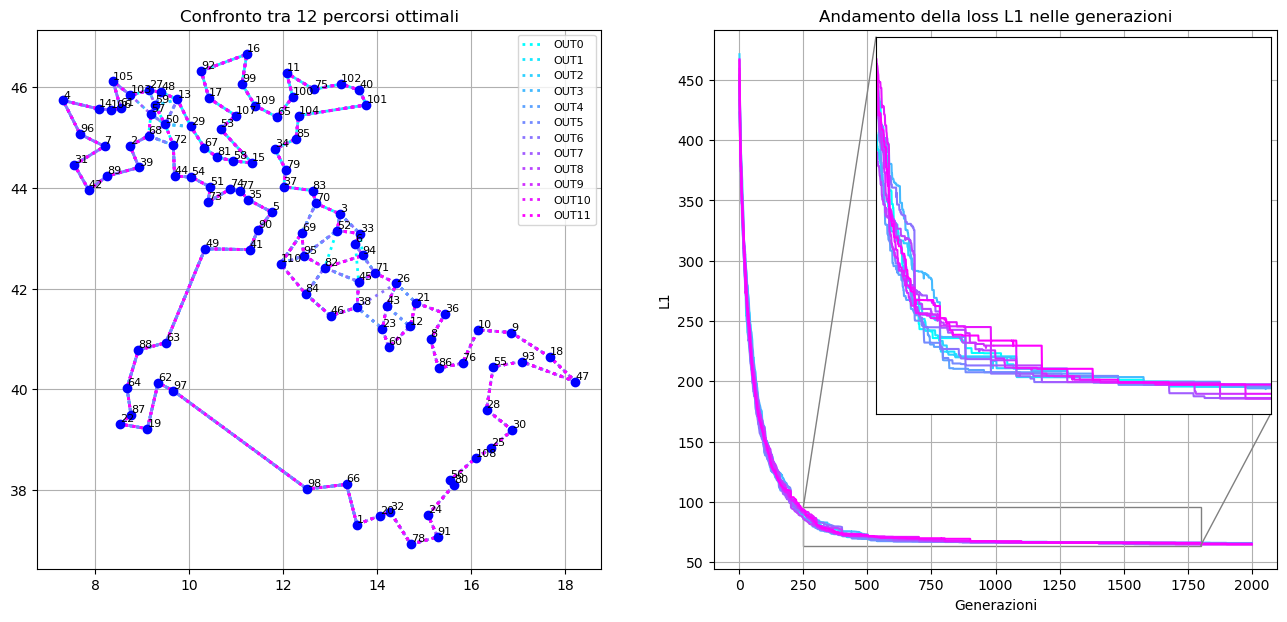

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Carica coordinate città
x, y = np.loadtxt('CONFIGS/cap_prov_ita.dat', unpack=True)
n_city = len(x)
all_gens = []
all_L1 = []

# Funzione per caricare e plottare un percorso sul dato ax
def plot_path_from_folder(folder, color, label, ax_path):
    filepath = os.path.join("OUTPUT", folder, "best.dat")
    if not os.path.exists(filepath):
        print(f"File non trovato: {filepath}")
        return
    path = np.loadtxt(filepath, dtype=int)
    path = np.append(path, path[0])
    x_ord = x[path - 1]
    y_ord = y[path - 1]
    ax_path.plot(x_ord, y_ord, linestyle=":", linewidth=2, color=color, label=label)

# Funzione per caricare e plottare la loss su ax_loss
def plot_L1_from_folder(folder, color, label, ax_loss):
    L1path = os.path.join("OUTPUT", folder, "L1.dat")
    if not os.path.exists(L1path):
        print(f"File non trovato: {L1path}")
        return
    gens, L1 = np.loadtxt(L1path, usecols=(0,1), unpack=True)
    ax_loss.plot(gens, L1, linestyle="-", color=color, label=label)
    all_gens.append(gens)
    all_L1.append(L1)

# Setup figura e subplots: 1 fila 2 colonne
fig, (ax_path, ax_loss) = plt.subplots(1, 2, figsize=(16, 7))

# Primo subplot: percorsi e città
ax_path.scatter(x, y, color='blue', zorder=3)
ax_path.set_title("Confronto tra 12 percorsi ottimali")
ax_path.grid(True)

for i in range(n_city):
    ax_path.text(x[i], y[i]+0.05, str(i+1), fontsize=8)

ax_loss.set_title("Andamento della loss L1 nelle generazioni")
ax_loss.set_xlabel("Generazioni")
ax_loss.set_ylabel("L1")
ax_loss.grid(True)

colors = plt.cm.cool(np.linspace(0, 1, 12))

# Plotta i percorsi
for i in range(12):
    folder = f"OUT{i}"
    label = f"OUT{i}"
    plot_path_from_folder(folder, colors[i], label, ax_path)
    plot_L1_from_folder(folder, colors[i], label, ax_loss)

ax_path.legend(fontsize=8)


# Inset zoom nel secondo subplot (per la loss) -> da chat.gpt
axins = inset_axes(ax_loss, width="70%", height="70%", loc='upper right')
zoom_xmin, zoom_xmax = 250, 1800
ymins, ymaxs = [], []

for i in range(len(all_gens)):
    gens_i = all_gens[i]
    L1_i = all_L1[i]
    mask = (gens_i >= zoom_xmin) & (gens_i <= zoom_xmax)
    if np.any(mask):
        axins.plot(gens_i[mask], L1_i[mask], color=colors[i])
        ymins.append(np.min(L1_i[mask]))
        ymaxs.append(np.max(L1_i[mask]))

axins.set_xlim(zoom_xmin, zoom_xmax)
if ymins and ymaxs:
    axins.set_ylim(min(ymins)*0.98, max(ymaxs)*1.02)
axins.set_xticks([])
axins.set_yticks([])
mark_inset(ax_loss, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()


# Percorso migliore trovato dal core 8 lungo = 65.0143
Percorso migliore trovato dal singolo core lungo =  68.8815


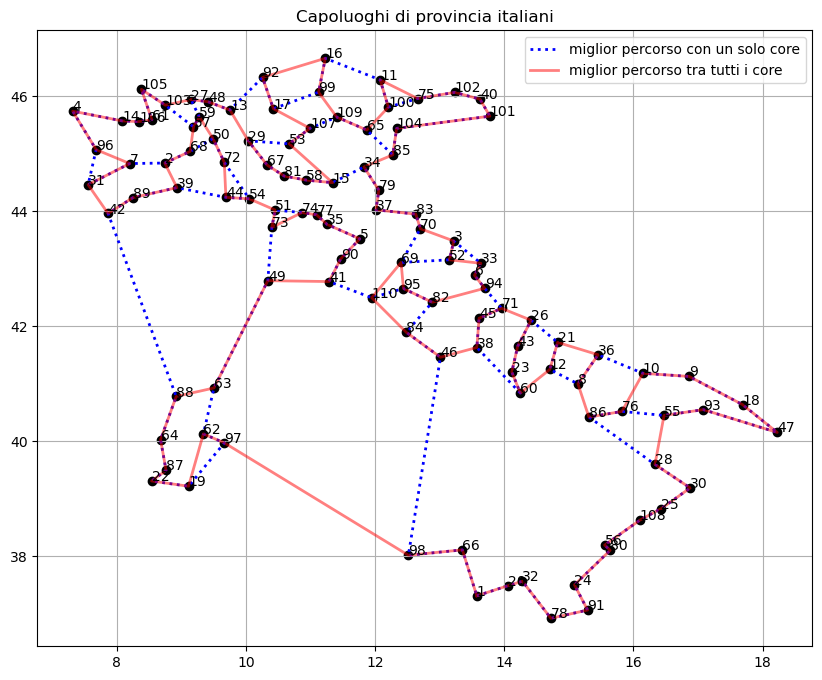

In [22]:
import numpy as np
import matplotlib.pyplot as plt

with open("OUTPUT/best_of_the_best.dat", "r") as file:
    prima_riga = file.readline().strip()
print(prima_riga)

L1 = np.loadtxt("../Lezione9/OUTPUT/L1_cap.dat" , usecols=(1), unpack=True)
print("Percorso migliore trovato dal singolo core lungo = ", L1[-1])

# carica coordinate città
x, y = np.loadtxt('CONFIGS/cap_prov_ita.dat', unpack=True)
n_city = len(x)

path = np.loadtxt("OUTPUT/best_of_the_best.dat", dtype=int)
path = np.append(path, path[0])
x_ord = x[path - 1]
y_ord = y[path - 1]

path1 = np.loadtxt("../Lezione9/OUTPUT/best_cap.dat", dtype=int)
path1 = np.append(path1, path1[0])
x1_ord = x[path1 - 1]
y1_ord = y[path1 - 1]

# plot
plt.figure(figsize=(10, 8))
plt.scatter(x, y, color='black')
plt.title("Capoluoghi di provincia italiani")
plt.grid(True)

for i in range(n_city):
    plt.text(x[i], y[i], str(i + 1), fontsize=10)

plt.plot(x1_ord, y1_ord, color='blue', linestyle=":", linewidth=2, label='miglior percorso con un solo core')
plt.plot(x_ord, y_ord, color='red', linestyle="-", linewidth=2, label='miglior percorso tra tutti i core', alpha=0.5)
plt.legend()
plt.show()

Sopra è riportato un secondo grafico che confronta il miglior percorso trovato tramite due diverse configurazioni computazionali:
* Simulazione parallela: eseguita su 12 core, ciascuno con una popolazione di 1000 individui, con meccanismi di migrazione periodica tra le sottopopolazioni (continenti).
* Simulazione seriale: eseguita su un unico processo, con una popolazione di 12'000 individui (pari alla somma delle popolazioni parallele), mantenendo costante il numero totale di generazioni.

Questo confronto evidenzia l’efficienza superiore dell’approccio parallelo con migrazione, che consente di esplorare lo spazio delle soluzioni in modo più efficace e di convergere più rapidamente verso soluzioni ottimali.
<br>Nonostante la parità teorica in termini di dimensione della popolazione globale e numero di generazioni, la struttura a continenti permette di mantenere una maggiore diversità genetica locale all’interno di ciascun core.
Questo approccio riduce significativamente il rischio di convergenza prematura verso minimi locali, di conseguenza producendo soluzioni generalmente migliori.